Signal transfer line chart created


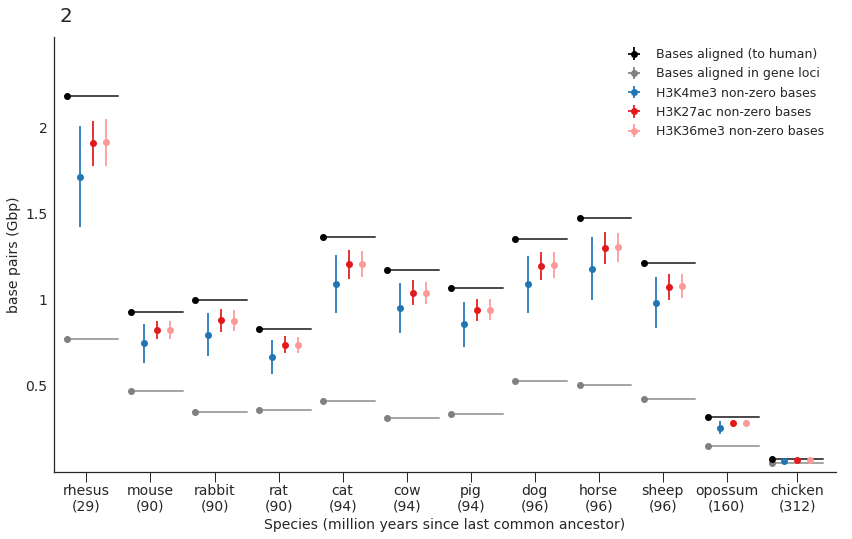

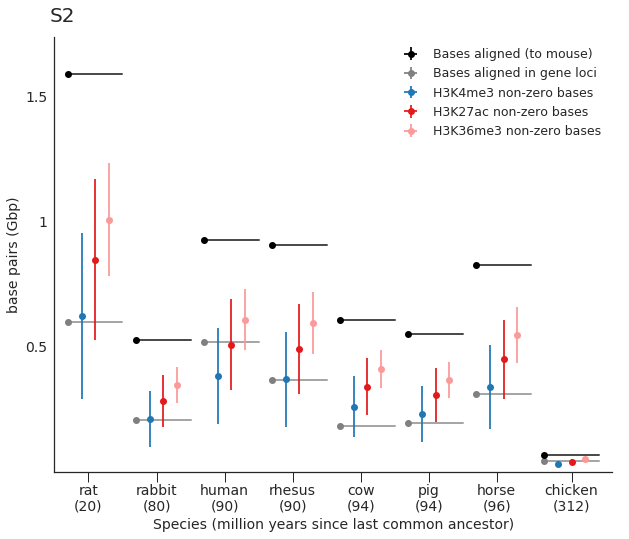

In [4]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn
import itertools as itt

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_1samp as tt

# What is this?
# Plot summary as error dot plot
# of transferred histone signal
# and alignable bases


date = '20180418'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

transfer_signal = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_signal_mapping/mapsig')
source_signal = os.path.join(fhgfs_base, '/TL/deep/fhgfs/projects/pebert/thesis/projects/cross_species/rawdata/conv/hdf')
mapidx = os.path.join(fhgfs_base, 'refdata/chainfiles/hdf_map')
featfiles = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_testdata_exp/compfeat_groups')

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
spec_lut = plot_colors['mapping']
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_transfer_epigenome = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
diss_folder = '/home/pebert/work/code/mpggit/dissertation/Figures'
save_figures = True
save_diss = False

color_k4 = tuple(x / 255 for x in [31,120,180])
color_k27 = tuple(x / 255 for x in [227,26,28])
color_k36 = tuple(x / 255 for x in [251,154,153])


def exec_transfer_epigenome(out_folder):
    cache_file = os.path.join(cache_dir, '{}_plot_signal_transfer.pck'.format(date))
    if not os.path.isfile(cache_file):
        bp_counts = collect_bp_counts()
        with open(cache_file, 'wb') as cache:
            pck.dump(bp_counts, cache)
    else:
        with open(cache_file, 'rb') as cache:
            bp_counts = pck.load(cache)
            
    cache_gene_cov = os.path.join(cache_dir, '{}_gene_aln_cov.pck'.format(date))
    if not os.path.isfile(cache_gene_cov):
        gene_cov = collect_gene_cov()
        with open(cache_gene_cov, 'wb') as cache:
            pck.dump(gene_cov, cache)
    else:
        with open(cache_gene_cov, 'rb') as cache:
            gene_cov = pck.load(cache)      
            
    lca_pairs = []
    with open(lca_times_file, 'r') as lca:
        trg = lca.readline().split()[1:]
        for line in lca:
            if line:
                cols = line.strip().split()
                ref = cols[0]
                if ref not in ['human', 'mouse']:
                    continue
                lca_pairs.extend([(int(y), ref, trg) for trg, y in zip(trg, cols[1:])])
            
    for fkey, ref in zip(['2', 'S2'], ['human', 'mouse']):
        ref_pairs = [l for l in lca_pairs if l[1] == ref]
        ref_assm = spec_lut[ref]['assembly']
        ref_aln = [(key[1], rec) for key, rec in bp_counts['alignment'].items() if key[0] == ref_assm]
        ref_src = [(key[1], rec) for key, rec in bp_counts['source'].items() if key[0] == ref_assm]
        ref_trans = [(key[1], key[2], rec) for key, rec in bp_counts['transfer'].items() if key[0] == ref_assm]
        
        ref_genes = [(key[0], key[1], rec) for key, rec in gene_cov.items() if key[0] == ref_assm]
        
        use_comb = set((key[0], key[1]) for key, rec in bp_counts['transfer'].items() if key[0] == ref_assm)
        title = fkey
        fig, exart = plot_transfer_lines(ref, ref_assm, ref_pairs,
                                         ref_aln, ref_src, ref_trans,
                                         ref_genes, use_comb, title, save_diss)
        if save_figures:
            outname = 'fig_{}_transfer_nz-signal'.format(fkey)
            if save_diss:
                out_folder = diss_folder
                subfolder = 'crossspecies'
            else:
                if ref == 'human':
                    subfolder = 'main'
                else:
                    subfolder = 'supp'

            if not save_diss:
                outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

                outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
    return True


def collect_gene_cov():
    
    gene_cov = col.Counter()
    done = set()
    for root, dirs, files in os.walk(featfiles):
        if files:
            q, _, t = os.path.split(root)[-1].split('_')
            if (t, q, 'body') not in done:
                bodyfile = [f for f in files if '.body.' in f and f.endswith('.h5')][0]
                fpath = os.path.join(root, bodyfile)
                with pd.HDFStore(fpath, 'r') as hdf:
                    for k in hdf.keys():
                        if k != '/metadata':
                            data = hdf[k]
                            data = data.loc[:, ['start', 'end', 'ftmsig_H3K36me3_pct_cons']]
                            data['length'] = data['end'] - data['start']
                            data['cov_bp'] = np.round(data['length'] * (data['ftmsig_H3K36me3_pct_cons'] / 100), 0)
                            gene_cov[(t, q)] += data['cov_bp'].sum()
                done.add((t, q, 'body'))
            if (t, q, 'prom') not in done:
                promfile = [f for f in files if '.reg5p.' in f and f.endswith('.h5')][0]
                fpath = os.path.join(root, promfile)
                with pd.HDFStore(fpath, 'r') as hdf:
                    for k in hdf.keys():
                        if k != '/metadata':
                            data = hdf[k]
                            data = data.loc[:, ['start', 'end', 'ftmsig_H3K4me3_pct_cons']]
                            data['length'] = data['end'] - data['start']
                            data['cov_bp'] = np.round(data['length'] * (data['ftmsig_H3K4me3_pct_cons'] / 100), 0)
                            gene_cov[(t, q)] += data['cov_bp'].sum()
                done.add((t, q, 'prom'))

    return gene_cov            


def collect_bp_counts():
    
    collect_gsize = dict()
    print('Collecting source signal info')
    collect_source = col.defaultdict(list)
    for root, dirs, sigfiles in os.walk(source_signal):
        if sigfiles:
            for sf in sigfiles:
                if sf.endswith('genes.h5'):
                    continue
                fpath = os.path.join(root, sf)
                eid, assm, cell, mark = sf.split('.')[0].split('_')
                if eid == 'EE04' and mark == 'H3K27ac':
                    continue
                genome_cov = 0
                genome_size = 0
                with pd.HDFStore(fpath, 'r') as hdf:
                    for k in hdf.keys():
                        if k == '/metadata':
                            continue
                        data = hdf[k]
                        genome_size += data.size
                        nonzero = np.array(data > 0, dtype=np.int8).sum()
                        genome_cov += nonzero
                collect_source[(assm, mark)].append(int(genome_cov))
                if assm not in collect_gsize:
                    collect_gsize[assm] = int(genome_size)
    
    print('Collecting transferred signal info')
    collect_transfer = col.defaultdict(list)
    for root, dirs, transfiles in os.walk(transfer_signal):
        if transfiles:
            for tf in transfiles:
                fpath = os.path.join(root, tf)
                finfo, _, ref, _, _ = tf.split('.')
                eid, trg, cell, mark = finfo.split('_')
                if eid == 'EE04' and mark == 'H3K27ac':
                    continue
                genome_cov = 0
                genome_size = 0
                with pd.HDFStore(fpath, 'r') as hdf:
                    for k in hdf.keys():
                        if k == '/metadata':
                            continue
                        data = hdf[k]
                        genome_size += data.size
                        nonzero = np.array(data > 0, dtype=np.int8).sum()
                        genome_cov += nonzero
                collect_transfer[(ref, trg, mark)].append(int(genome_cov))
                if assm not in collect_gsize:
                    collect_gsize[assm] = genome_size

    print('Collecting alignment info')
    collect_aln = dict()
    for root, dirs, mapindices in os.walk(mapidx):
        if mapindices:
            for mi in mapindices:
                if mi.endswith('.idx.h5'):
                    ref, _, trg = mi.split('.')[0].split('_')
                    fpath = os.path.join(root, mi)
                    t_cov, q_cov = 0, 0
                    with pd.HDFStore(fpath, 'r') as hdf:
                        for k in hdf.keys():
                            if k.startswith('/target/cons/mask'):
                                msk = hdf[k]
                                cov = np.array(~msk, dtype=np.int8).sum()
                                t_cov += cov
                            elif k.startswith('/query/cons/mask'):
                                msk = hdf[k]
                                cov = np.array(~msk, dtype=np.int8).sum()
                                q_cov += cov
                            else:
                                continue
                        assert t_cov == q_cov, 'Target / query mismatch: {} vs {} / {}'.format(t_cov, q_cov, mi)
                        collect_aln[(ref, trg)] = int(t_cov)  
    collector = {'source': collect_source,
                 'transfer': collect_transfer,
                 'gsize': collect_gsize,
                 'alignment': collect_aln}
    return collector


def plot_transfer_lines(species, assembly, species_pairs,
                        bp_aln, bp_source, bp_trans, bp_genes,
                        assm_comb, title, diss_version):
    
    use_assm = set([t[0] for t in assm_comb]).union(set([t[1] for t in assm_comb]))
    
    if species == 'human':
        fig, ax = plt.subplots(figsize=(14, 8))
    else:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    total_comb = len(assm_comb)  #+ 1  # +1 for ref-ref --- reference species removed
    vals_per_comb = 4
    space_step = 1
    sum_xvals = total_comb * (vals_per_comb + space_step)
    
    x_vals = np.linspace(1, sum_xvals + 1, num=sum_xvals, endpoint=True)
    x_vals_aln = np.arange(1, x_vals.size, step=5)
    x_vals_k4 = np.arange(2, x_vals.size, step=5)
    x_vals_k27 = np.arange(3, x_vals.size, step=5)
    x_vals_k36 = np.arange(4, x_vals.size, step=5)
    
    ref_aln = np.array([t[1] for t in bp_aln if t[0] in use_assm], dtype=np.int64)
    ref_aln_mean, ref_aln_std = make_bootstrap_est(ref_aln)
    
    ref_k4 = np.array([t[1] for t in bp_source if t[0] == 'H3K4me3'][0])
    ref_k4_mean, ref_k4_std = make_bootstrap_est(ref_k4)
    
    ref_k27 = np.array([t[1] for t in bp_source if t[0] == 'H3K27ac'][0])
    ref_k27_mean, ref_k27_std = make_bootstrap_est(ref_k27)
    
    ref_k36 = np.array([t[1] for t in bp_source if t[0] == 'H3K36me3'][0])
    ref_k36_mean, ref_k36_std = make_bootstrap_est(ref_k36)
    
    ylim = np.array([ref_aln_mean + ref_aln_std, ref_k4_mean + ref_k4_std,
                     ref_k27_mean + ref_k27_std, ref_k36_mean + ref_k36_std]).max()
    scale = ylim // 10000000
    ylim = (scale + 1) * 10000000
    
    ax.set_xlim(0, x_vals.size + 1)
    ax.set_ylim(0, ylim)
            
    # CHANGE HERE TO INCLUDE REFERENCE SPECIES
    # removed upon Christophs request
    
    # collect data for target species
#     y_vals_aln = [ref_aln_mean]
#     y_vals_aln_std = [ref_aln_std]
#     y_vals_k4 = [ref_k4_mean]
#     y_vals_k4_std = [ref_k4_std]
#     y_vals_k27 = [ref_k27_mean]
#     y_vals_k27_std = [ref_k27_std]
#     y_vals_k36 = [ref_k36_mean]
#     y_vals_k36_std = [ref_k36_std]
    
    y_vals_aln = []
    y_vals_aln_std = []
    y_vals_genes = []
    y_vals_genes_std = []
    y_vals_k4 = []
    y_vals_k4_std = []
    y_vals_k27 = []
    y_vals_k27_std = []
    y_vals_k36 = []
    y_vals_k36_std = []
    
    x_labels = []
    for y, r, t in sorted(species_pairs):
        if y == 0:
            #x_labels.append(t) --- reference species removed
            continue  # reference species already done
        t_assm = spec_lut[t]['assembly']
        if t_assm not in use_assm:
            continue
        x_labels.append('{}\n({})'.format(t, y))
        
        y_vals_aln.append([t[1] for t in bp_aln if t[0] == t_assm][0])
        y_vals_aln_std.append(0)
        
        y_vals_genes.append([t[2] for t in bp_genes if t[1] == t_assm][0])
        y_vals_genes_std.append(0)
        
        k4 = np.array([t[2] for t in bp_trans if t[0] == t_assm and t[1] == 'H3K4me3'][0])
        k4_mean, k4_std = make_bootstrap_est(k4)
        y_vals_k4.append(k4_mean)
        y_vals_k4_std.append(k4_std)
        
        k27 = np.array([t[2] for t in bp_trans if t[0] == t_assm and t[1] == 'H3K27ac'][0])
        k27_mean, k27_std = make_bootstrap_est(k27)
        y_vals_k27.append(k27_mean)
        y_vals_k27_std.append(k27_std)
        
        k36 = np.array([t[2] for t in bp_trans if t[0] == t_assm and t[1] == 'H3K36me3'][0])
        k36_mean, k36_std = make_bootstrap_est(k36)
        y_vals_k36.append(k36_mean)
        y_vals_k36_std.append(k36_std)

    aln_dots = ax.errorbar(x_vals_aln, y_vals_aln,
                           xerr=0, yerr=y_vals_aln_std,
                           fmt='o', color='black', label='Bases aligned (to {})'.format(species))
    
    gene_dots = ax.errorbar(x_vals_aln, y_vals_genes,
                            xerr=0, yerr=y_vals_genes_std,
                            fmt='o', color='grey', zorder=1,
                            label='Bases aligned in gene loci')
    
    ax.errorbar(x_vals_k4, y_vals_k4, xerr=0, yerr=y_vals_k4_std, fmt='o',
                color=color_k4, label='H3K4me3 non-zero bases')
    ax.errorbar(x_vals_k27, y_vals_k27, xerr=0, yerr=y_vals_k27_std, fmt='o',
                color=color_k27, label='H3K27ac non-zero bases')
    k36_dots = ax.errorbar(x_vals_k36, y_vals_k36,
                           xerr=0, yerr=y_vals_k36_std, fmt='o',
                           color=color_k36, label='H3K36me3 non-zero bases')
    
    for aln_xy, gene_xy, k36_xy in zip(aln_dots.get_children()[0].get_xydata(),
                                       gene_dots.get_children()[0].get_xydata(),
                                       k36_dots.get_children()[0].get_xydata()):
        x_start = aln_xy[0]
        x_end = k36_xy[0] + 1
        y = aln_xy[1]
        
        ax.plot([x_start, x_end], [y, y],
                color='black', alpha=0.7,
                linewidth=2, linestyle='solid',
                label='', zorder=0)
        
        x_start = gene_xy[0]
        x_end = k36_xy[0] + 1
        y = gene_xy[1]
        
        ax.plot([x_start, x_end], [y, y],
                color='grey', alpha=0.7,
                linewidth=2, linestyle='solid',
                label='', zorder=1)
    
    x_ticks = (np.array(x_vals_k27) + np.array(x_vals_k4)) / 2.
    # labels opossum and chicken are close together, make a litte space
    x_ticks[-1] = x_vals_k27[-1]
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=14, rotation=0)
    
    if species == 'human': 
        ax.set_yticks([5e8, 1e9, 1.5e9, 2e9])
        ax.set_yticklabels(['0.5', '1', '1.5', '2'], fontsize=14)
    else:
        ax.set_yticks([5e8, 1e9, 1.5e9])
        ax.set_yticklabels(['0.5', '1', '1.5'], fontsize=14)
    
    ax.tick_params(axis='x', which='major', direction='out',
                   length=10, pad=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend(loc='upper right')
    ax.set_xlabel('Species (million years since last common ancestor)', fontsize=14)
    ax.set_ylabel('base pairs (Gbp)', fontsize=14)
    
    if not diss_version:
        tt = ax.set_title(title, fontsize=20)
        tt.set_position([0.015, 1.02])
    
    return fig, []
    

def make_bootstrap_est(vals):
    
    bs = rng.choice(vals, size=(1000, vals.size), replace=True)
    
    bs_sampling_means = bs.mean(axis=1)
    bs_sampling_std = bs.std(axis=1)
    
    bs_mean_est = bs_sampling_means.mean()
    bs_std_est = bs_sampling_std.mean()
    return bs_mean_est, bs_std_est
 
    
if run_exec_transfer_epigenome:
    execd = exec_transfer_epigenome(out_folder)
    print('Signal transfer line chart created')
